# Creating the transport map between the two point clouds.

This notebook is used to compute the the optimal transport map for the two point clouds supported on $\mathtt{SE}(3)$. 

In [2]:
%matplotlib inline
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'notebook'])

In [3]:
target_pose = jnp.load('data/target_square_hole.npz')
initial_pose = jnp.load('data/initial_pose_1.npz')
target_pose.files, initial_pose.files

(['pose', 'q_vals', 'depth_image'], ['pose', 'q_vals', 'depth_image'])

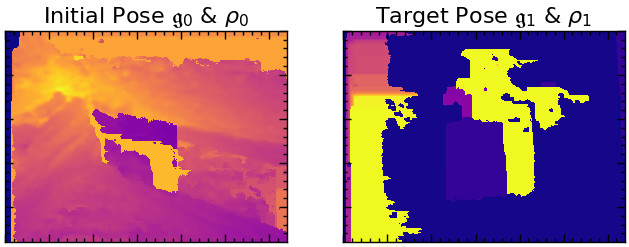

In [4]:
fig, ax = plt.subplots(1,2)

ax[0].set_title(r'Initial Pose $\mathfrak{g}_0$ & $\rho_0$')
ax[0].matshow(initial_pose['depth_image'], cmap=plt.cm.plasma)
ax[0].xaxis.set_tick_params(labeltop=False)
ax[0].yaxis.set_tick_params(labelleft=False)
ax[1].set_title(r'Target Pose $\mathfrak{g}_1$ & $\rho_1$')

pcm = ax[1].matshow(target_pose['depth_image'], cmap=plt.cm.plasma)
ax[1].xaxis.set_tick_params(labeltop=False)
ax[1].yaxis.set_tick_params(labelleft=False)

plt.show()

In [5]:
x = jnp.arange(0, 480, 1)
y = jnp.arange(0, 640, 1)
X, Y = jnp.meshgrid(x, y)
X.shape, Y.shape

((640, 480), (640, 480))

In [6]:
# Target pose
target_cloud = 0.01*target_pose['depth_image']
target_cloud[target_cloud>100] = 0.0
target_pose_se3 = target_pose['pose']

# Initial pose
initial_cloud = 0.01*initial_pose['depth_image']
initial_pose_se3 = initial_pose['pose']

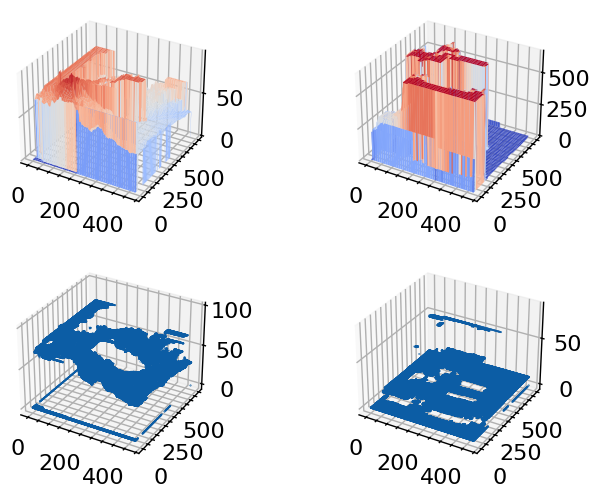

In [7]:
fig, ax = plt.subplots(2,2, subplot_kw={"projection": "3d"})
surf_1 = ax[0,0].plot_surface(X.T, Y.T, 0.01*initial_pose['depth_image'], cmap=plt.cm.coolwarm) # It is multiplied by 0.01cm to turn the raw depth map into something readable
surf_2 = ax[0,1].plot_surface(X.T, Y.T, 0.01*target_pose['depth_image'], cmap=plt.cm.coolwarm)
scatter_1 = ax[1,0].scatter(X, Y, initial_cloud.T, s=0.1)
scatter_2 = ax[1,1].scatter(X, Y, target_cloud.T, s=0.1)

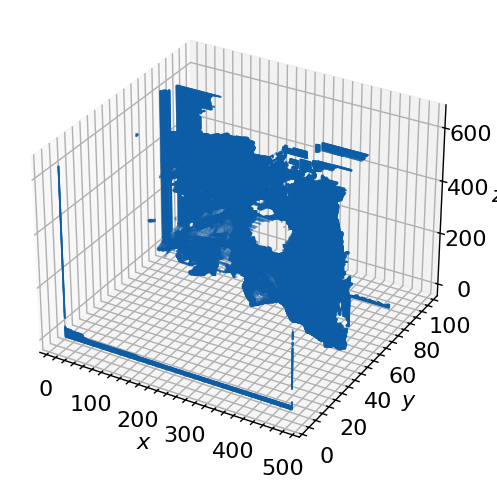

In [8]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(X, initial_cloud.T, Y, s=0.1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
plt.show()

Now that we can plot the data in both surface and scatter plot form, we want to see if we can use the `ott-jax` library to compute the optimal transport map between the initial and target poses. Once we have that, we can look at computing controllability matrices. 

In [9]:
import ott
from ott.geometry import costs, pointcloud
from ott import utils
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.tools import plot
from tqdm.notebook import trange, tqdm

An important thing here is the representation of the point cloud in some 3D array. The ground cost can be added as well, such that we include the geodesic distance $d(\mathfrak{g}_0, \mathfrak{g}_1)$.  

In [10]:
g_0 = jnp.vstack([X.ravel(), Y.ravel(), initial_cloud.T.ravel()]).T
g_1 = jnp.vstack([X.ravel(), Y.ravel(), target_cloud.T.ravel()]).T
g_0.shape, g_1.shape

((307200, 3), (307200, 3))

In [11]:
geom = pointcloud.PointCloud(g_0[0:30000,:], g_1[0:30000,:], epsilon=1e-3)
geom.cost_matrix

Array([[0.0000000e+00, 1.0000000e+00, 4.0000000e+00, ..., 6.0013000e+04,
        6.0488000e+04, 6.0965000e+04],
       [1.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 5.9540000e+04,
        6.0013000e+04, 6.0488000e+04],
       [4.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 5.9069000e+04,
        5.9540000e+04, 6.0013000e+04],
       ...,
       [6.2932242e+04, 6.2459242e+04, 6.1988242e+04, ..., 2.9192422e+03,
        2.9202422e+03, 2.9232422e+03],
       [6.3408320e+04, 6.2933320e+04, 6.2460320e+04, ..., 2.9213203e+03,
        2.9203203e+03, 2.9213203e+03],
       [6.3885320e+04, 6.3408320e+04, 6.2933320e+04, ..., 2.9243203e+03,
        2.9213203e+03, 2.9203203e+03]], dtype=float32)

In [17]:
tau = 0.999
ot_prob = linear_problem.LinearProblem(geom, tau_a=tau, tau_b=tau)
with tqdm(ncols='500px') as pbar:
    progress_fn = utils.tqdm_progress_fn(pbar)
    solver = sinkhorn.Sinkhorn(progress_fn=progress_fn)
    ot = jax.jit(solver)(ot_prob)
    
print(
    " Sinkhorn has converged: ",
    ot.converged,
    "\n",
    "Error upon last iteration: ",
    ot.errors[(ot.errors > -1)][-1],
    "\n",
    "Sinkhorn required ",
    jnp.sum(ot.errors > -1),
    " iterations to converge. \n",
    "Entropy regularized OT cost: ",
    ot.ent_reg_cost,
    "\n",
    "OT cost (without entropy): ",
    jnp.sum(ot.matrix * ot.geom.cost_matrix),
)

0it [00:00, ?it/s]

2025-04-24 21:30:42.011477: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.35GiB (rounded to 3600000000)requested by op 
2025-04-24 21:30:42.011565: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] *___******____*********************************************************************************_____
E0424 21:30:42.011581   64860 pjrt_stream_executor_client.cc:3026] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 3600000000 bytes. [tf-allocator-allocation-error='']
2025-04-24 21:30:52.151261: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.35GiB (rounded to 3600000000)requested by op 
2025-04-24 21:30:52.151367: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] *___******____*********************************************************************************_____
E0424 21:30:52.151383   64860 pjrt_stream_

ValueError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 3600000000 bytes.

In [14]:
dp = ot.to_dual_potentials()
dp.transport(g_0[0:15000,:]).shape

(15000, 3)

<function matplotlib.pyplot.show(close=None, block=None)>

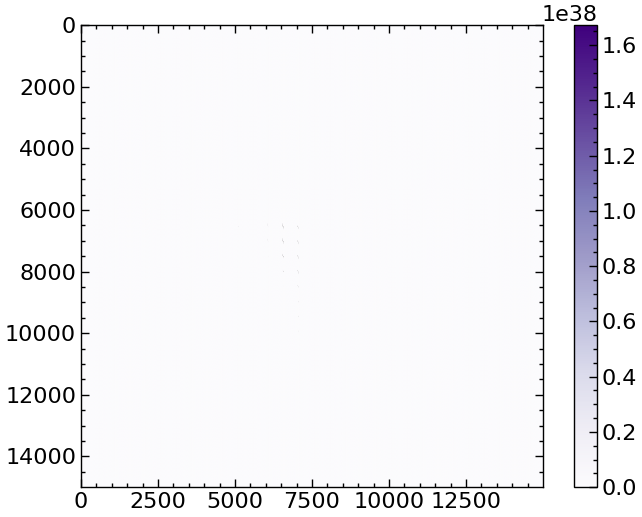

In [15]:
P = ot.matrix
plt.figure()
plt.imshow(P, cmap="Purples")
plt.colorbar();
plt.show

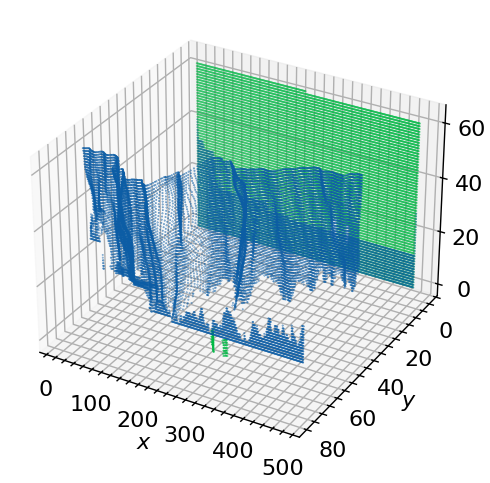

In [12]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(g_0[0:30000,0], g_0[0:30000,2], g_0[0:30000,1], s=0.1)
ax.scatter(g_1[0:30000,0], g_1[0:30000,2], g_1[0:30000,1], s=0.1)
ax.yaxis.set_inverted(True)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
plt.show()